In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.mixture import GaussianMixture

import numpy as np

SEED = 42

In [2]:
fifa_df = pd.read_csv("/content/sample_data/FIFA23_official_data.csv")

In [3]:
fifa_df.columns

Index(['ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Joined', 'Loaned From', 'Contract Valid Until', 'Height', 'Weight',
       'Release Clause', 'Kit Number', 'Best Overall Rating'],
      dtype='object')

In [4]:
fifa_columns = ['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Height', 'Weight']

In [5]:
fifa_df.head()

ID             Name  Age  \
0  209658      L. Goretzka   27   
1  212198  Bruno Fernandes   27   
2  224334         M. Acuña   30   
3  192985     K. De Bruyne   31   
4  224232       N. Barella   25   

                                              Photo Nationality  \
0  https://cdn.sofifa.net/players/209/658/23_60.png     Germany   
1  https://cdn.sofifa.net/players/212/198/23_60.png    Portugal   
2  https://cdn.sofifa.net/players/224/334/23_60.png   Argentina   
3  https://cdn.sofifa.net/players/192/985/23_60.png     Belgium   
4  https://cdn.sofifa.net/players/224/232/23_60.png       Italy   

                                  Flag  Overall  Potential               Club  \
0  https://cdn.sofifa.net/flags/de.png       87         88  FC Bayern München   
1  https://cdn.sofifa.net/flags/pt.png       86         87  Manchester United   
2  https://cdn.sofifa.net/flags/ar.png       85         85         Sevilla FC   
3  https://cdn.sofifa.net/flags/be.png       91         91    Manchester City   
4  https://cdn.sofifa.net/flags/it.png       86         89              Inter   

                                 Club Logo  ... Real Face  \
0   https://cdn.sofifa.net/teams/21/30.png  ...       Yes   
1   https://cdn.sofifa.net/teams/11/30.png  ...       Yes   
2  https://cdn.sofifa.net/teams/481/30.png  ...        No   
3   https://cdn.sofifa.net/teams/10/30.png  ...       Yes   
4   https://cdn.sofifa.net/teams/44/30.png  ...       Yes   

                      Position        Joined Loaned From  \
0  <span class="pos pos28">SUB   Jul 1, 2018         NaN   
1  <span class="pos pos15">LCM  Jan 30, 2020         NaN   
2    <span class="pos pos7">LB  Sep 14, 2020         NaN   
3  <span class="pos pos13">RCM  Aug 30, 2015         NaN   
4  <span class="pos pos13">RCM   Sep 1, 2020         NaN   

   Contract Valid Until  Height  Weight Release Clause Kit Number  \
0                  2026   189cm    82kg          €157M        8.0   
1                  2026   179cm    69kg          €155M        8.0   
2                  2024   172cm    69kg         €97.7M       19.0   
3                  2025   181cm    70kg        €198.9M       17.0   
4                  2026   172cm    68kg        €154.4M       23.0   

  Best Overall Rating  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 29 columns]

In [6]:
fifa_df = fifa_df[fifa_columns].copy()
# vamos a convertir las columnas en minusculas y sin espacios
fifa_df.columns = fifa_df.columns.str.lower().str.replace(' ', '_')
fifa_df.head()
fifa_df.head()

age  overall  potential    value   wage  special preferred_foot  \
0   27       87         88     €91M  €115K     2312          Right   
1   27       86         87   €78.5M  €190K     2305          Right   
2   30       85         85   €46.5M   €46K     2303           Left   
3   31       91         91  €107.5M  €350K     2303          Right   
4   25       86         89   €89.5M  €110K     2296          Right   

   international_reputation  weak_foot  skill_moves height weight  
0                       4.0        4.0          3.0  189cm   82kg  
1                       3.0        3.0          4.0  179cm   69kg  
2                       2.0        3.0          3.0  172cm   69kg  
3                       4.0        5.0          4.0  181cm   70kg  
4                       3.0        3.0          3.0  172cm   68kg

In [7]:
fifa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17660 entries, 0 to 17659
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       17660 non-null  int64  
 1   overall                   17660 non-null  int64  
 2   potential                 17660 non-null  int64  
 3   value                     17660 non-null  object 
 4   wage                      17660 non-null  object 
 5   special                   17660 non-null  int64  
 6   preferred_foot            17660 non-null  object 
 7   international_reputation  17660 non-null  float64
 8   weak_foot                 17660 non-null  float64
 9   skill_moves               17660 non-null  float64
 10  height                    17660 non-null  object 
 11  weight                    17660 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 1.6+ MB


In [8]:
!gdown '1GqKdZpAyyC4pi5tAJmcz3QxJREDT7-34'

Downloading...
From: https://drive.google.com/uc?id=1GqKdZpAyyC4pi5tAJmcz3QxJREDT7-34
To: /content/fifa_df.csv
100% 3.00M/3.00M [00:00<00:00, 63.4MB/s]


In [9]:
# En el dataset seleccionado vemos que las columnas con valores tipo moneda tienen caracteristicas de € y M o K según sea el valor
# por ende, debemos convertir los valores a una misma base y eliminar los caracteres de moneda
def convertir_valor(x):
    if not isinstance(x, str):
        return x
    x = x.replace('€', '').strip()
    if x.endswith('M'):
        return float(x[:-1]) * 1_000_000
    elif x.endswith('K'):
        return float(x[:-1]) * 1_000
    else:
        return float(x)

In [10]:
# Ahora vamos a usar la funcion para modificar los caracteres especiales y dejar la misma base
fifa_df['value'] = fifa_df['value'].apply(convertir_valor)
fifa_df['wage'] = fifa_df['wage'].apply(convertir_valor)
# vemos que la altura y peso tambien tienen caracteres alfanumericos, los transformamos
fifa_df['height'] = fifa_df['height'].astype(str).str.replace('cm', '').astype(float)
fifa_df['weight'] = fifa_df['weight'].astype(str).str.replace('kg', '').astype(float)
# para tener un dataset numerico convertimos la columna de pie preferido en binaria con {'Right': 1, 'Left': 0}
fifa_df['preferred_foot'] = fifa_df['preferred_foot'].map({'Right': 1, 'Left': 0})
fifa_df.head()

age  overall  potential        value      wage  special  preferred_foot  \
0   27       87         88   91000000.0  115000.0     2312               1   
1   27       86         87   78500000.0  190000.0     2305               1   
2   30       85         85   46500000.0   46000.0     2303               0   
3   31       91         91  107500000.0  350000.0     2303               1   
4   25       86         89   89500000.0  110000.0     2296               1   

   international_reputation  weak_foot  skill_moves  height  weight  
0                       4.0        4.0          3.0   189.0    82.0  
1                       3.0        3.0          4.0   179.0    69.0  
2                       2.0        3.0          3.0   172.0    69.0  
3                       4.0        5.0          4.0   181.0    70.0  
4                       3.0        3.0          3.0   172.0    68.0

In [11]:
# Ahora debemos escalar los datos dado que tenemos diferencias muy apreciables en las columnas de datos de moneda y las otras
scaler = MinMaxScaler()
fifa_df[fifa_df.columns] = scaler.fit_transform(fifa_df[fifa_df.columns])
fifa_df.head()

age   overall  potential     value      wage   special  \
0  0.307692  0.916667   0.867925  0.477690  0.255556  1.000000   
1  0.307692  0.895833   0.849057  0.412073  0.422222  0.995521   
2  0.384615  0.875000   0.811321  0.244094  0.102222  0.994242   
3  0.410256  1.000000   0.924528  0.564304  0.777778  0.994242   
4  0.256410  0.895833   0.886792  0.469816  0.244444  0.989763   

   preferred_foot  international_reputation  weak_foot  skill_moves    height  \
0             1.0                      0.75       0.75         0.50  0.701754   
1             1.0                      0.50       0.50         0.75  0.526316   
2             0.0                      0.25       0.50         0.50  0.403509   
3             1.0                      0.75       1.00         0.75  0.561404   
4             1.0                      0.50       0.50         0.50  0.403509   

     weight  
0  0.548387  
1  0.338710  
2  0.338710  
3  0.354839  
4  0.322581

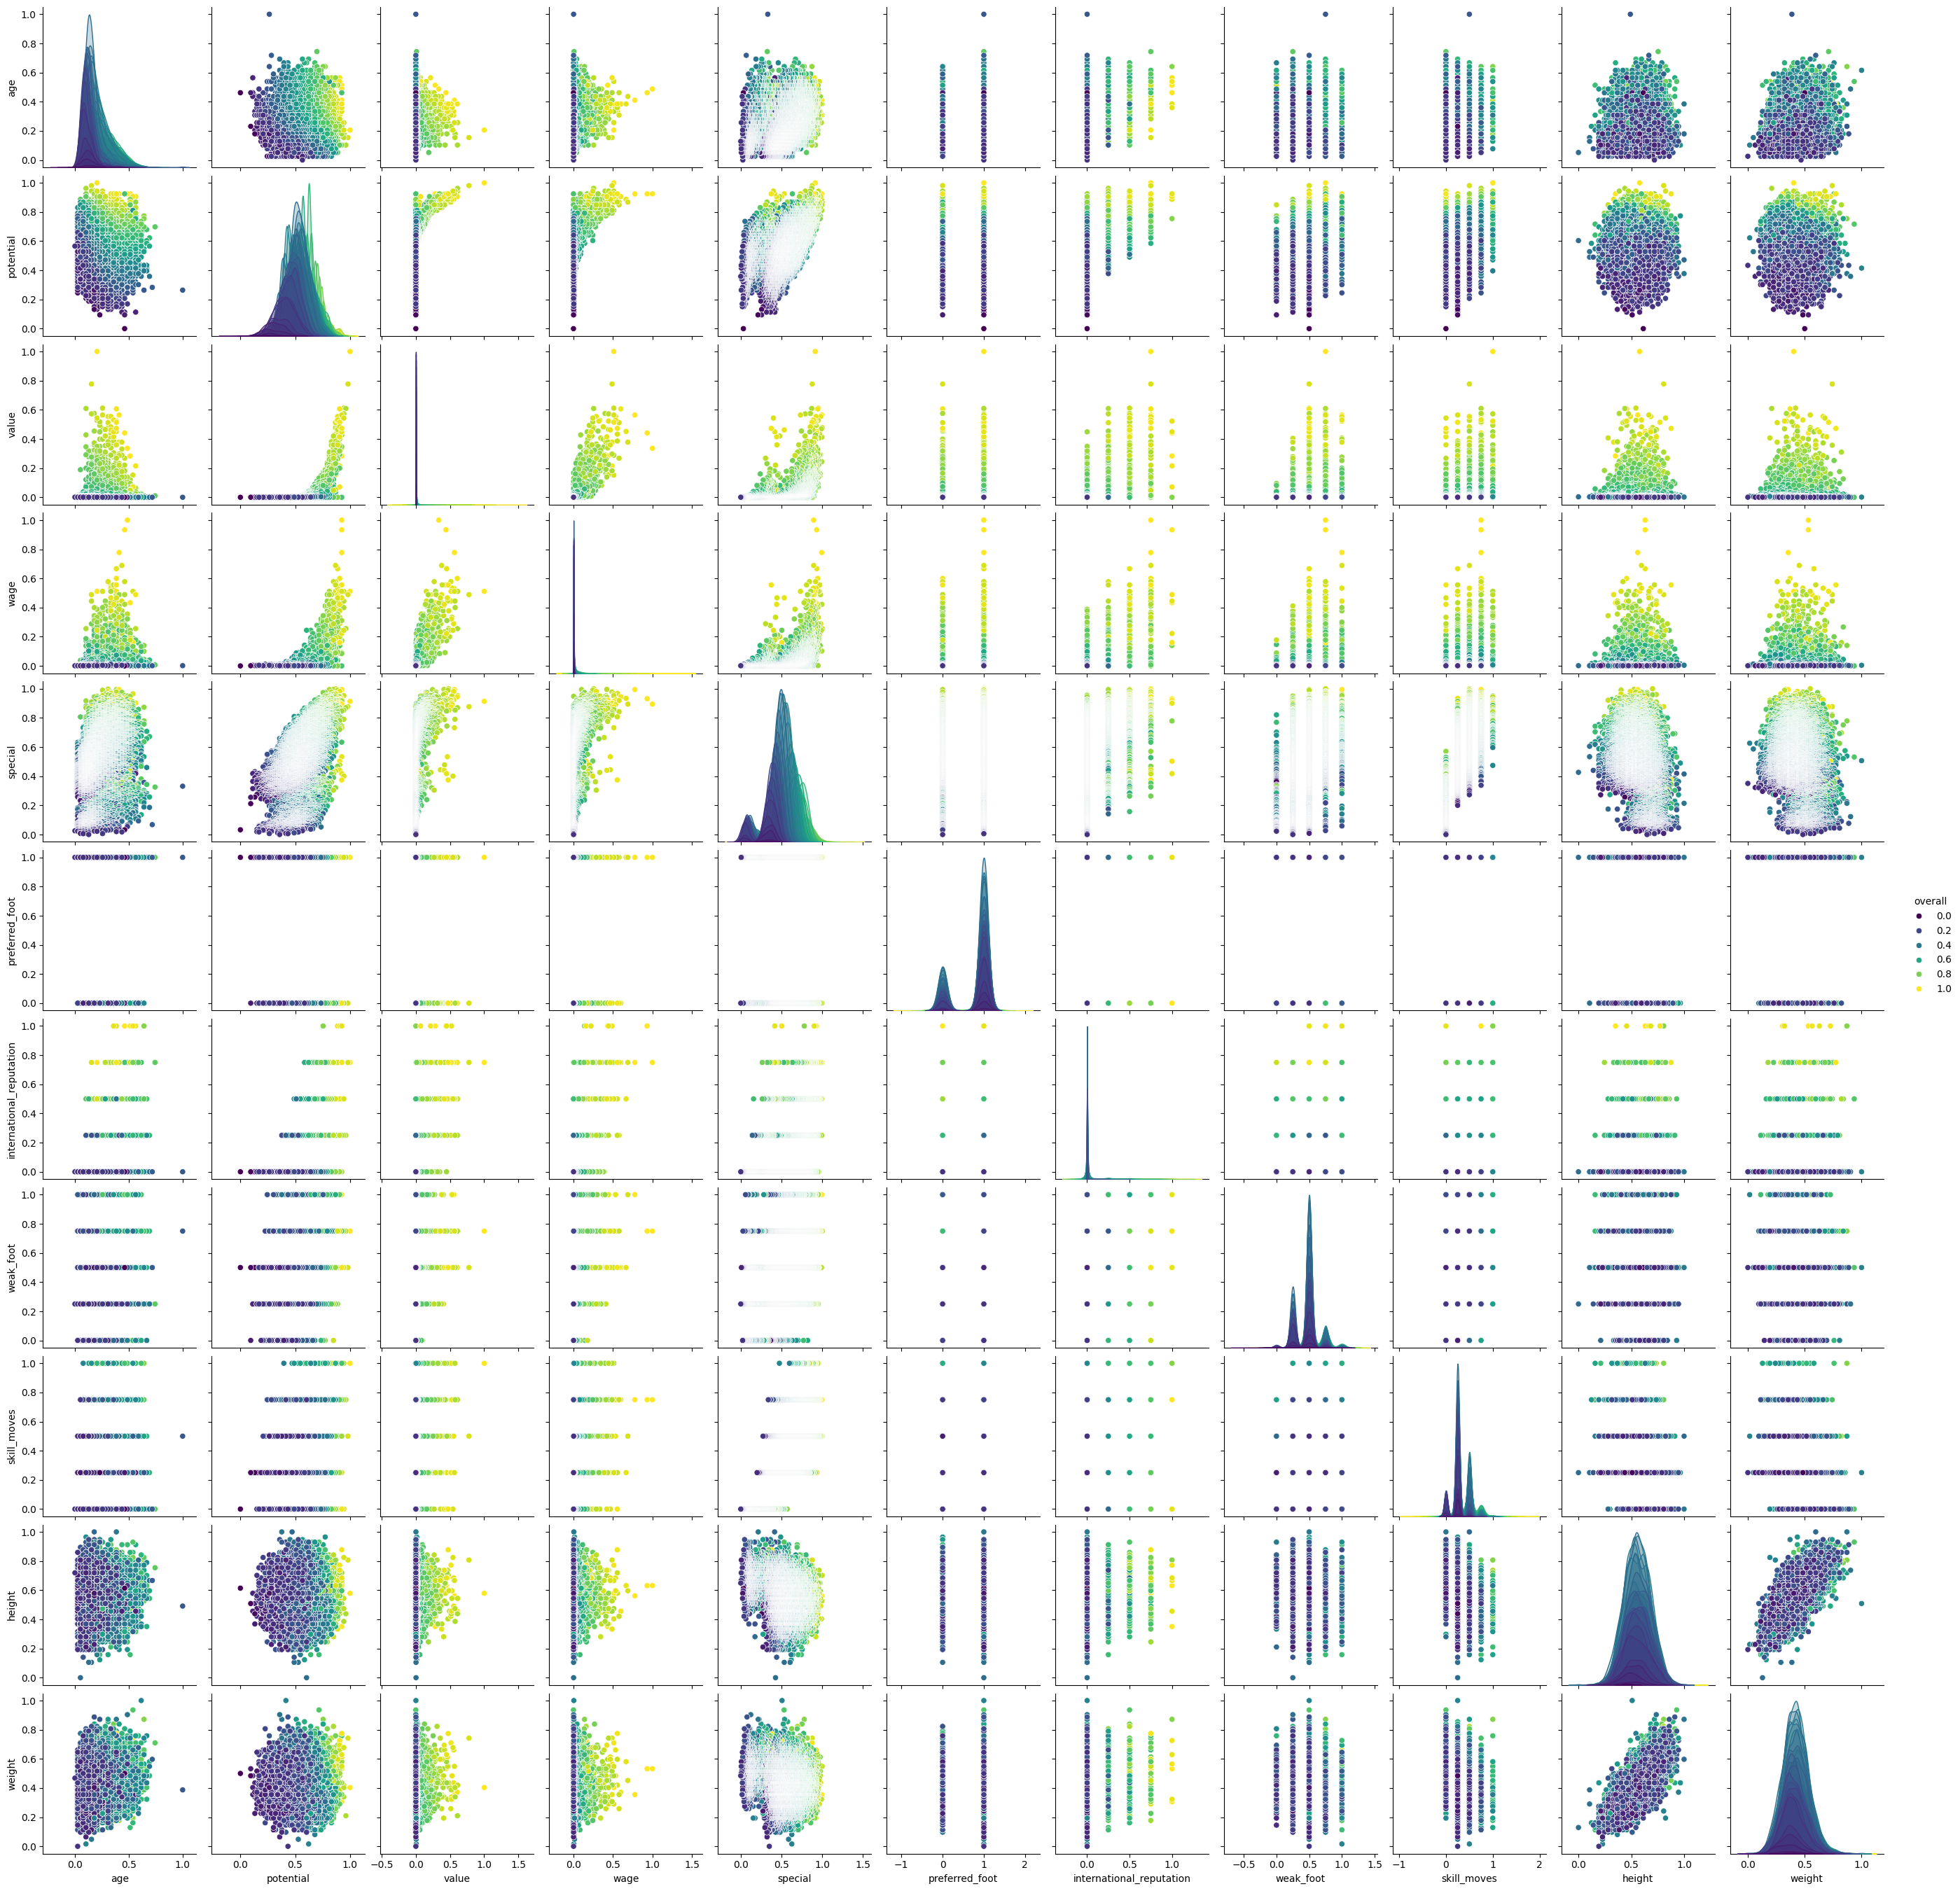

In [12]:
import seaborn as sns
sns.pairplot(fifa_df, hue="overall", palette='viridis')

# KNN

In [13]:
# Con nuestro dataset establecido y escalado procedemos a implementar el metodo del codo y
# la silueta para determinar el numero optimo de clusters

def scatter_plot(X, y=None):
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(figsize=(7, 4))

  if y is None:
    ax.scatter(X[:, 0], X[:, 2], marker=".", s=10)
  else:
    ax.scatter(X[:, 0], X[:, 2], marker=".", s=10, c=y)

  ax.set_xlabel("$x_1$", fontsize=14)
  ax.set_ylabel("$x_2$", fontsize=14)
  ax.tick_params(axis='both', labelsize=8)

  ax.grid(False)
  plt.tight_layout()

  plt.savefig("scatter.png", dpi=600, transparent=True)

  plt.show()

In [14]:
def train_kmeans(X):
    ks = np.linspace(2, 8, 7, dtype=np.int64)  # Generaremos 7 clusters de 2 a 8
    inertias = []
    silhouettes = []
    davies_bouldin = []
    kmeans_k = []

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=SEED)
        kmeans.fit(X)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
        davies_bouldin.append(davies_bouldin_score(X, kmeans.labels_))
        kmeans_k.append(kmeans)

    return kmeans_k, inertias, silhouettes, davies_bouldin, ks


In [15]:
kmeans_k, inertias, silhouettes, davies_bouldin_knn, ks = train_kmeans(fifa_df)

In [34]:
def print_kmeans_results(kmeans_k, inertias, silhouettes, davies_bouldin, ks):
    print("\nResultados de KMeans:")
    print("{:^10} {:^15} {:^15} {:^20}".format("Clusters", "Inertia", "Silhouette", "Davies-Bouldin Index"))
    print("-" * 60)
    for i in range(len(ks)):
        print("{:^10} {:^15.2f} {:^15.4f} {:^20.4f}".format(ks[i], inertias[i], silhouettes[i], davies_bouldin[i]))

print_kmeans_results(kmeans_k, inertias, silhouettes, davies_bouldin_knn, ks)


Resultados de KMeans:
 Clusters      Inertia       Silhouette    Davies-Bouldin Index
------------------------------------------------------------
    2          3432.85         0.5116             0.7943       
    3          3236.57         0.4449             1.2404       
    4          2417.47         0.2892             1.4508       
    5          2119.30         0.2564             1.4273       
    6          1954.20         0.2140             1.5828       
    7          1813.08         0.2102             1.5065       
    8          1730.88         0.2004             1.5498       


### Metodo del codo

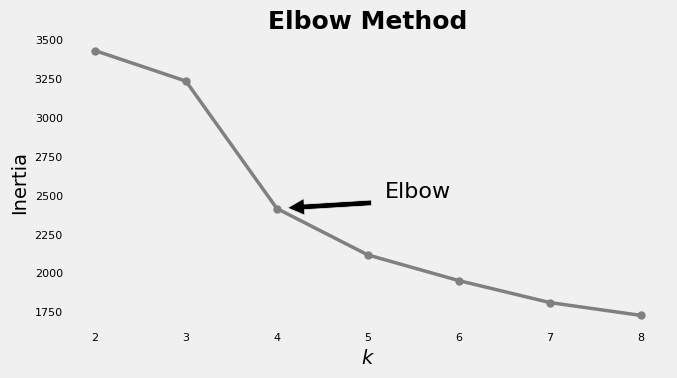

In [17]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks, inertias, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Inertia", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Elbow Method", fontsize=18, fontweight="bold")
ax.grid(False)

ax.annotate("Elbow",
            xy=(4, inertias[2]),
            xytext=(0.55, 0.45),
            textcoords="figure fraction",
            fontsize=16,
            arrowprops=dict(facecolor="black", shrink=0.1)
            )

plt.tight_layout()
plt.savefig("elbow.png", dpi=600, transparent=True)
plt.show()

### Metodo de la silueta

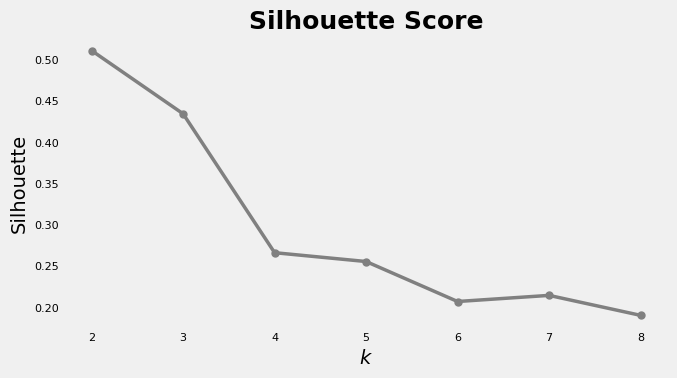

In [18]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks, silhouettes, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Silhouette", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Silhouette Score", fontsize=18, fontweight="bold")
ax.grid(False)

# ax.annotate("silhouette score = {:.2f}".format(silhouettes[3]),
#             xy=(5, silhouettes[3]),
#             xytext=(0.65, 0.8),
#             textcoords="figure fraction",
#             fontsize=12,
#             arrowprops=dict(facecolor="black", shrink=0.1)
#             )

plt.tight_layout()
plt.savefig("silhouette_score.png", dpi=600, transparent=True)
plt.show()

### Diagrama de silueta por clusters

For n_clusters = 3 The average silhouette_score is : 0.4349669494738797
For n_clusters = 4 The average silhouette_score is : 0.26666439288947985
For n_clusters = 5 The average silhouette_score is : 0.2559608737983133
For n_clusters = 6 The average silhouette_score is : 0.20752184577288846


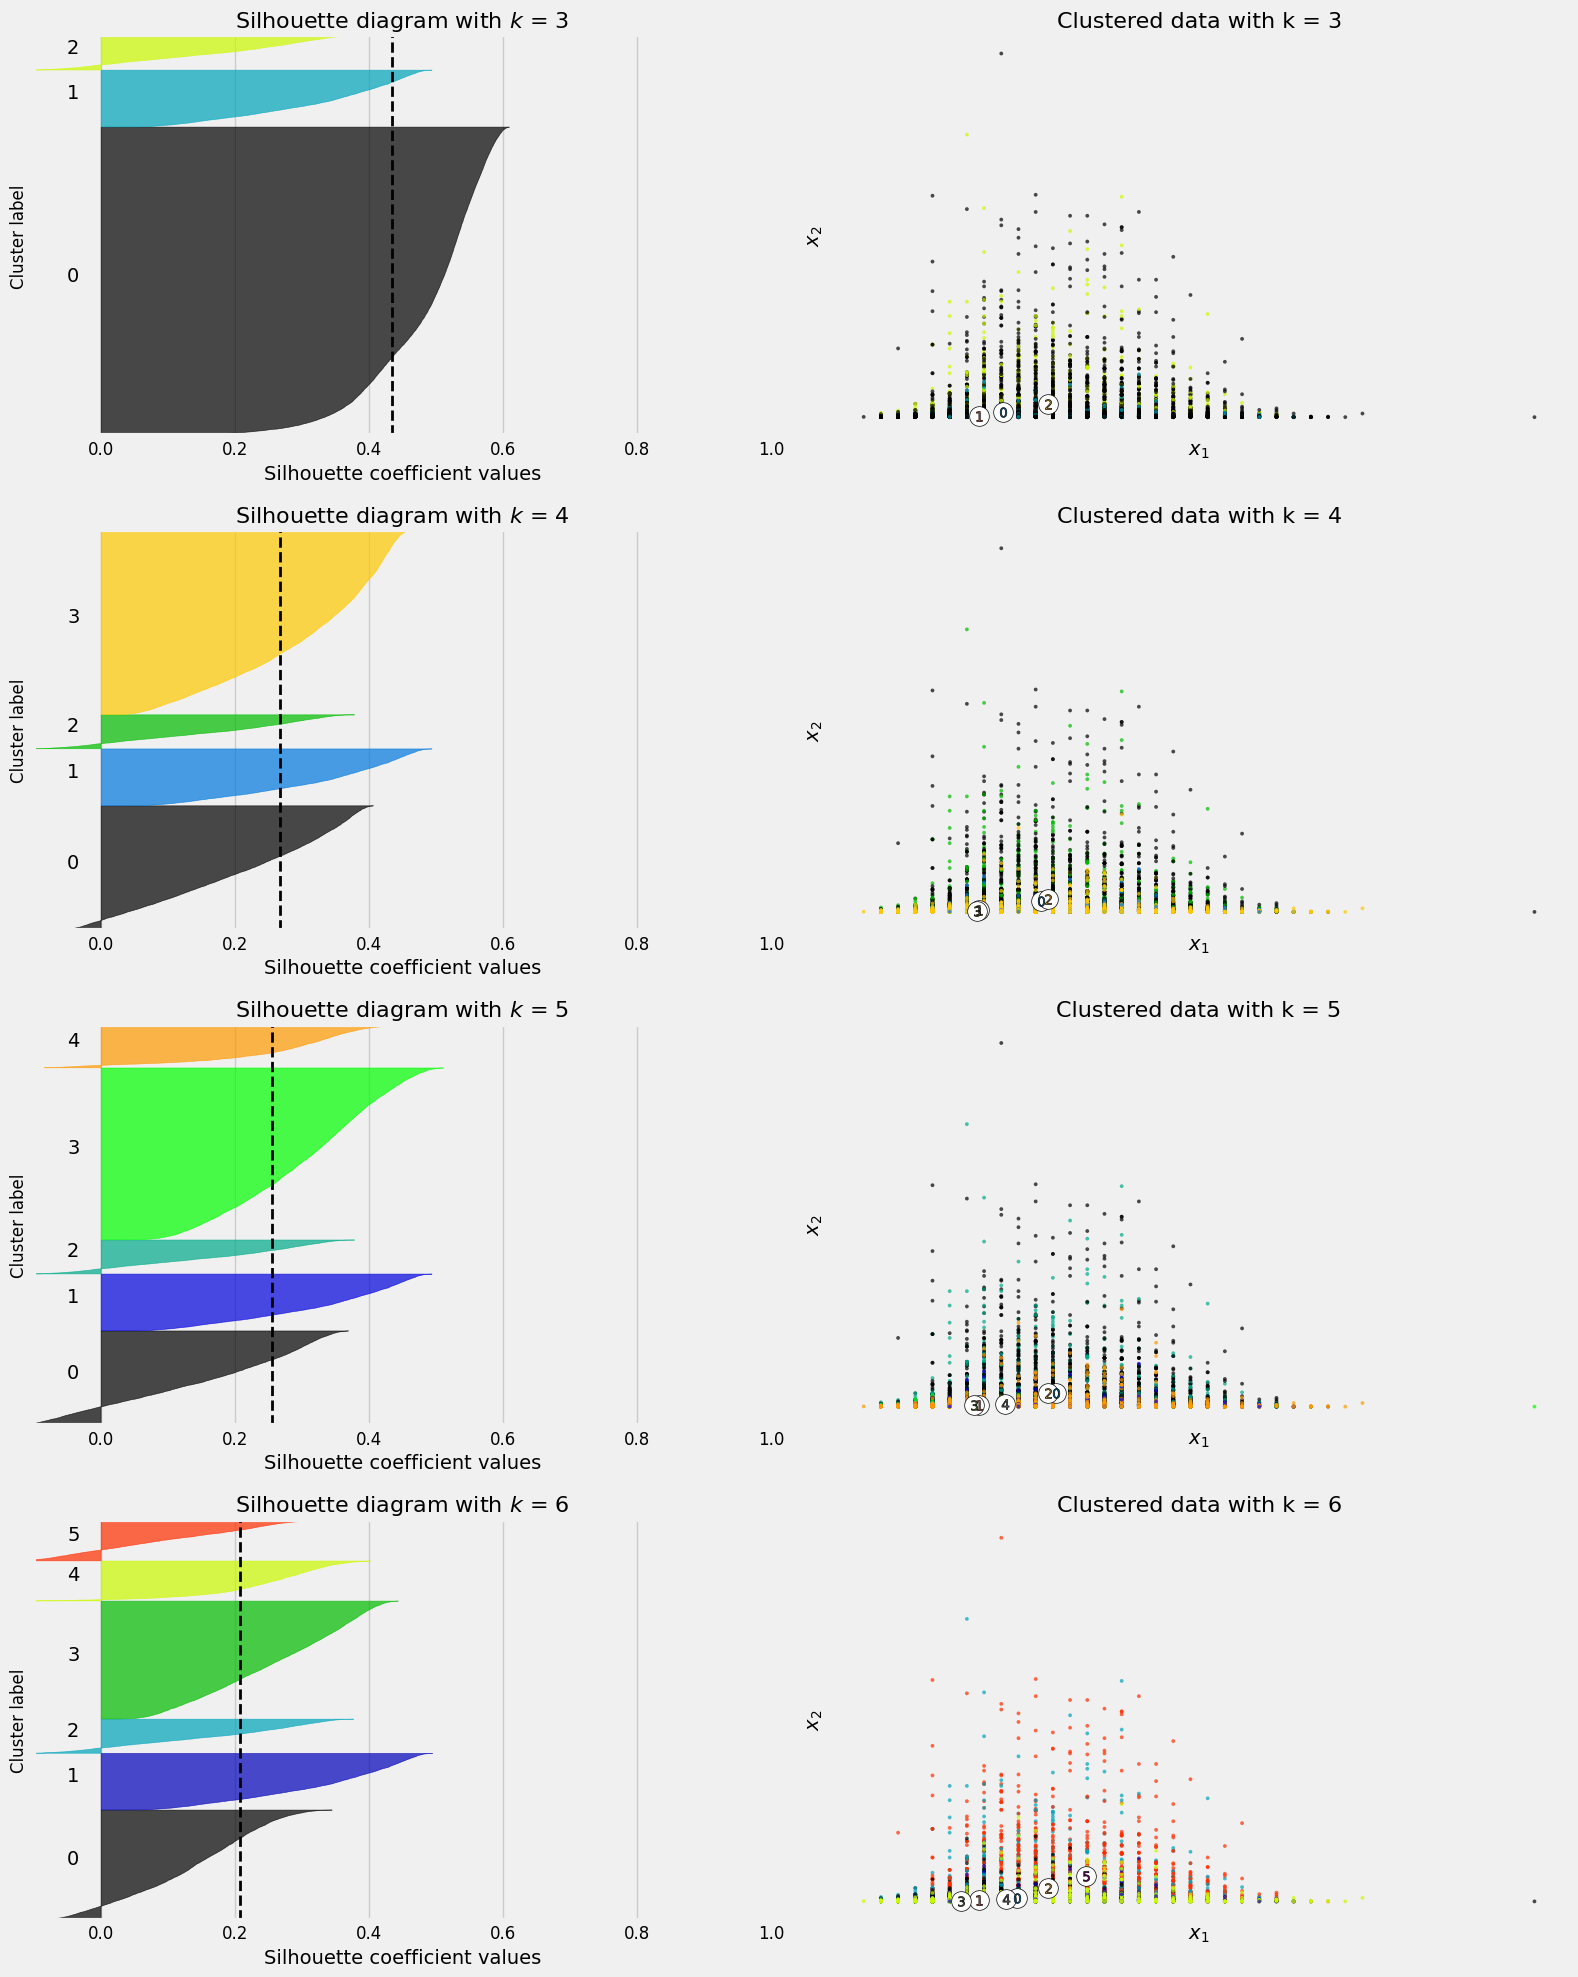

In [19]:
range_n_clusters = [3, 4, 5, 6]

fig, ax = plt.subplots(4, 2, figsize=(16, 20))

# [0, 0] [0, 1]
# [1, 0] [1, 1]
# [2, 0] [2, 1]
# [3, 0] [3, 1]

for row, n_clusters in enumerate(range_n_clusters):

  # Create a subplot with 1 row and 2 columns
  # fig, (ax1, ax2) = plt.subplots(1, 2)

  # fig.set_size_inches(12, 6)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax[row, 0].set_xlim([-0.1, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax[row, 0].set_ylim([0, len(fifa_df) + (n_clusters + 1) * 10])

  # get predictions for each label
  cluster_labels = kmeans_k[n_clusters-2].predict(fifa_df)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(fifa_df, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette score for each sample
  sample_silhouette_values = silhouette_samples(fifa_df, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[row, 0].fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax[row, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[row, 0].set_title("Silhouette diagram with $k$ = {}".format(n_clusters), fontsize=16)
  ax[row, 0].set_xlabel("Silhouette coefficient values", fontsize=14)
  ax[row, 0].set_ylabel("Cluster label", fontsize=12)

  ax[row, 0].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax[row, 0].tick_params(axis='both', which='major', labelsize=12)

  # The vertical line for average silhouette score of all the values
  ax[row, 0].axvline(x=silhouette_avg, color="black", linestyle="--", linewidth=2)

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax[row, 1].scatter(fifa_df.iloc[:, 0], fifa_df.iloc[:, 3], marker='.', s=30, lw=0, alpha=0.7,
                     c=colors, edgecolor='k')

  # Labeling the clusters
  centers = kmeans_k[n_clusters-2].cluster_centers_
  # Draw white circles at cluster centers
  ax[row, 1].scatter(centers[:, 0], centers[:, 3], marker='o',
                     c="white", alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax[row, 1].scatter(c[0], c[3], marker='$%d$' % i, alpha=1,
                       s=50, edgecolor='k')

  ax[row, 1].set_title(f"Clustered data with k = {n_clusters}", fontsize=16)
  ax[row, 1].set_xlabel("$x_1$", fontsize=14)
  ax[row, 1].set_ylabel("$x_2$", fontsize=14)
  ax[row, 1].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 1].set_xticks([])

  ax[row, 1].grid(False)

  # fig.suptitle(("Silhouette analysis for KMeans clustering "
  # "with $k$ = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("silhouette_diagram.png", dpi=650, transparent=False)
plt.show()

### Resumen silueta

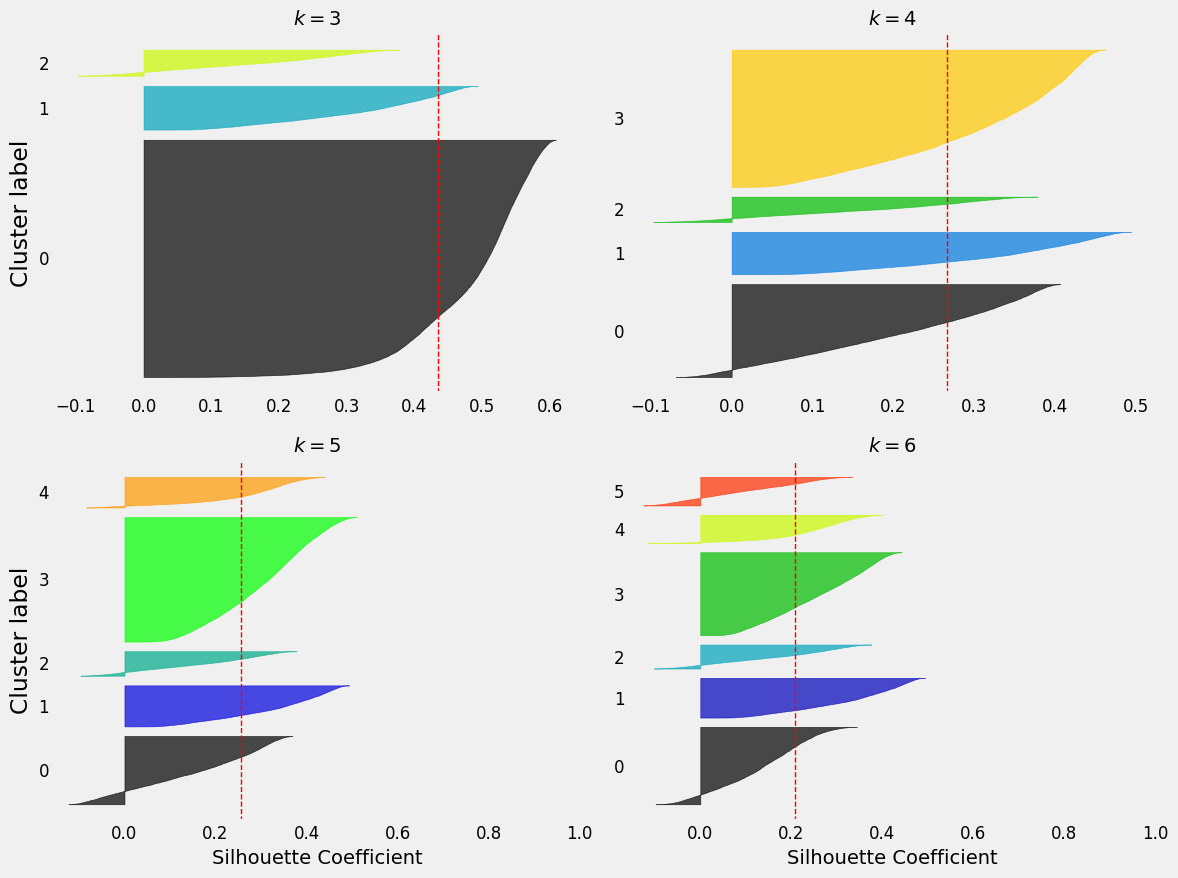

In [20]:
plt.figure(figsize=(12, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(fifa_df, y_pred)

    padding = len(fifa_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.nipy_spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster label")

    if k in (5, 6):
      plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
      plt.xlabel("Silhouette Coefficient", fontsize=14)
    # else:
    #     plt.tick_params(labelbottom=False)
    plt.tick_params(labelsize=12)
    plt.axvline(x=silhouettes[k - 2], color="red", linestyle="--", linewidth=1)
    plt.title("$k={}$".format(k), fontsize=14, fontweight="bold")

    plt.grid(False)

plt.tight_layout()
plt.show()

### Regiones de decision

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


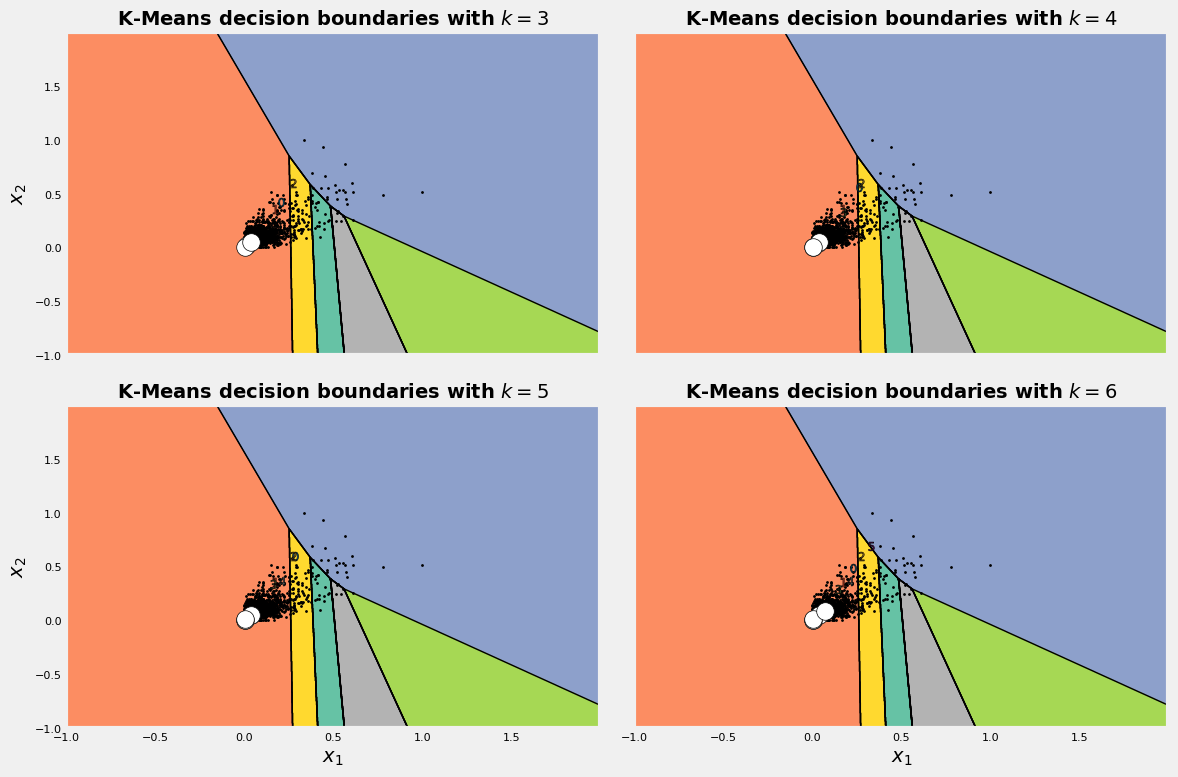

In [21]:
# Seleccionamos dos features relevantes
X_2d = fifa_df[['overall', 'value']]
# Entrenar KMeans en este subconjunto
kmeans_2d = KMeans(n_clusters=k, random_state=SEED)
kmeans_2d.fit(X_2d)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = fifa_df.iloc[:, 3].min() - 1, fifa_df.iloc[:, 4].max() + 1
y_min, y_max = fifa_df.iloc[:, 3].min() - 1, fifa_df.iloc[:, 4].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# [0, 0] [0, 1]
# [1, 0] [1, 1]

for i, j, k in zip([0, 0, 1, 1], [0, 1, 0, 1], [3, 4, 5, 6]):

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans_2d.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  ax[i, j].contourf(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap="Set2")
  ax[i, j].contour(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              linewidths=1, colors='k')

  ax[i, j].plot(fifa_df.iloc[:, 3], fifa_df.iloc[:, 4], 'k.', markersize=2)

  centers = kmeans_k[k-2].cluster_centers_
  ax[i, j].scatter(centers[:, 3], centers[:, 4], marker='o',
                  c="white", alpha=1, s=160, edgecolor='k', zorder=5)
  for cluster_idx, c in enumerate(centers):
    ax[i, j].scatter(c[0], c[1], marker='$%d$' % cluster_idx, alpha=1,
                    s=40, edgecolor='k', zorder=10)

  ax[i, j].set_title("K-Means decision boundaries with $k = {}$".format(k),
                    fontsize=14, fontweight="bold")

  if k % 2 == 1:
    ax[i, j].set_ylabel("$x_2$", fontsize=14)

  if k >= 5:
    ax[i, j].set_xlabel("$x_1$", fontsize=14)

  ax[i, j].tick_params(axis='both', labelsize=8)

  ax[i, j].grid(False)

plt.tight_layout()
plt.savefig("decision_boundaries.png", dpi=800, transparent=True)
plt.show()

# GMM

In [22]:
def train_gmm(X):
    ks_gmm = np.linspace(2, 8, 7, dtype=np.int64)  # Generamos 7 modelos GMM con k de 2 a 8
    bics = []
    silhouettes = []
    davies_bouldin = []
    gmm_models = []

    for k in ks_gmm:
        gmm = GaussianMixture(n_components=k, random_state=SEED)
        gmm.fit(X)

        # Se calcula el BIC; mientras menor sea, mejor se ajusta el modelo
        bic_val = gmm.bic(X)
        bics.append(bic_val)

        # Se obtienen las etiquetas para cada punto y se calcula el coeficiente de silueta
        labels = gmm.predict(X)
        silhouette_val = silhouette_score(X, labels)
        silhouettes.append(silhouette_val)

        # Se calcula Davies-Bouldin Index
        dbi_val = davies_bouldin_score(X, labels)
        davies_bouldin.append(dbi_val)

        gmm_models.append(gmm)

    return gmm_models, bics, silhouettes, davies_bouldin, ks_gmm


In [23]:
 gmm_models, bics, silhouettes, davies_bouldin_gmm, ks_gmm = train_gmm(fifa_df)

In [35]:
def print_gmm_results(gmm_models, bics, silhouettes, davies_bouldin, ks_gmm):
    print("\nResultados de GMM:")
    print("{:^10} {:^15} {:^15} {:^20}".format("Clusters", "BIC", "Silhouette", "Davies-Bouldin Index"))
    print("-" * 60)
    for i in range(len(ks_gmm)):
        print("{:^10} {:^15.2f} {:^15.4f} {:^20.4f}".format(ks_gmm[i], bics[i], silhouettes[i], davies_bouldin[i]))

print_gmm_results(gmm_models, bics, silhouettes, davies_bouldin_gmm, ks_gmm)


Resultados de GMM:
 Clusters        BIC         Silhouette    Davies-Bouldin Index
------------------------------------------------------------
    2        -619229.76        0.5116             0.7943       
    3        -675348.07        0.4449             1.2928       
    4        -874424.72        0.2892             1.5425       
    5        -898756.23        0.2564             1.4702       
    6        -973563.97        0.2140             1.6755       
    7        -928882.82        0.2102             1.8352       
    8        -988958.06        0.2004             1.8912       


### Metodo del codo

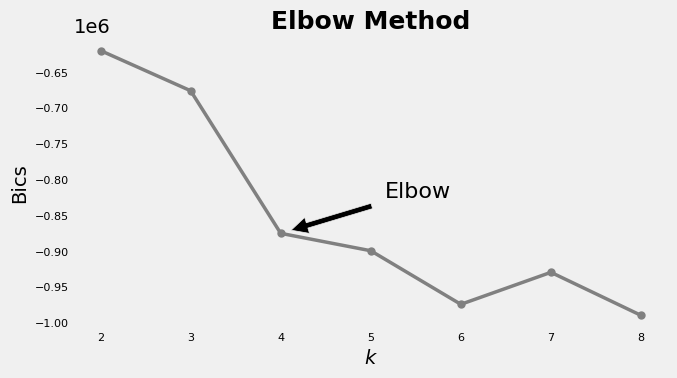

In [25]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks_gmm, bics, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Bics", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Elbow Method", fontsize=18, fontweight="bold")
ax.grid(False)

ax.annotate("Elbow",
            xy=(4, bics[2]),
            xytext=(0.55, 0.45),
            textcoords="figure fraction",
            fontsize=16,
            arrowprops=dict(facecolor="black", shrink=0.1)
            )

plt.tight_layout()
plt.savefig("elbow.png", dpi=600, transparent=True)
plt.show()

### Metodo de la silueta

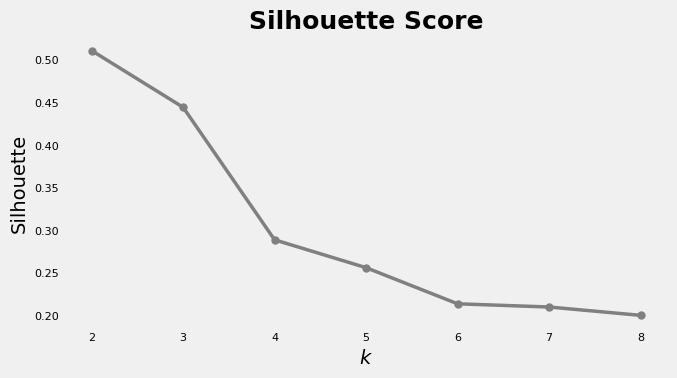

In [26]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks_gmm, silhouettes, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Silhouette", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Silhouette Score", fontsize=18, fontweight="bold")
ax.grid(False)

# ax.annotate("silhouette score = {:.2f}".format(silhouettes[3]),
#             xy=(5, silhouettes[3]),
#             xytext=(0.65, 0.8),
#             textcoords="figure fraction",
#             fontsize=12,
#             arrowprops=dict(facecolor="black", shrink=0.1)
#             )

plt.tight_layout()
plt.savefig("silhouette_score.png", dpi=600, transparent=True)
plt.show()

### Diagrama de silueta por clusters

For n_clusters = 3 The average silhouette_score is : 0.44491906251525004
For n_clusters = 4 The average silhouette_score is : 0.2891655146068599
For n_clusters = 5 The average silhouette_score is : 0.2564409690729826
For n_clusters = 6 The average silhouette_score is : 0.21400039640280435


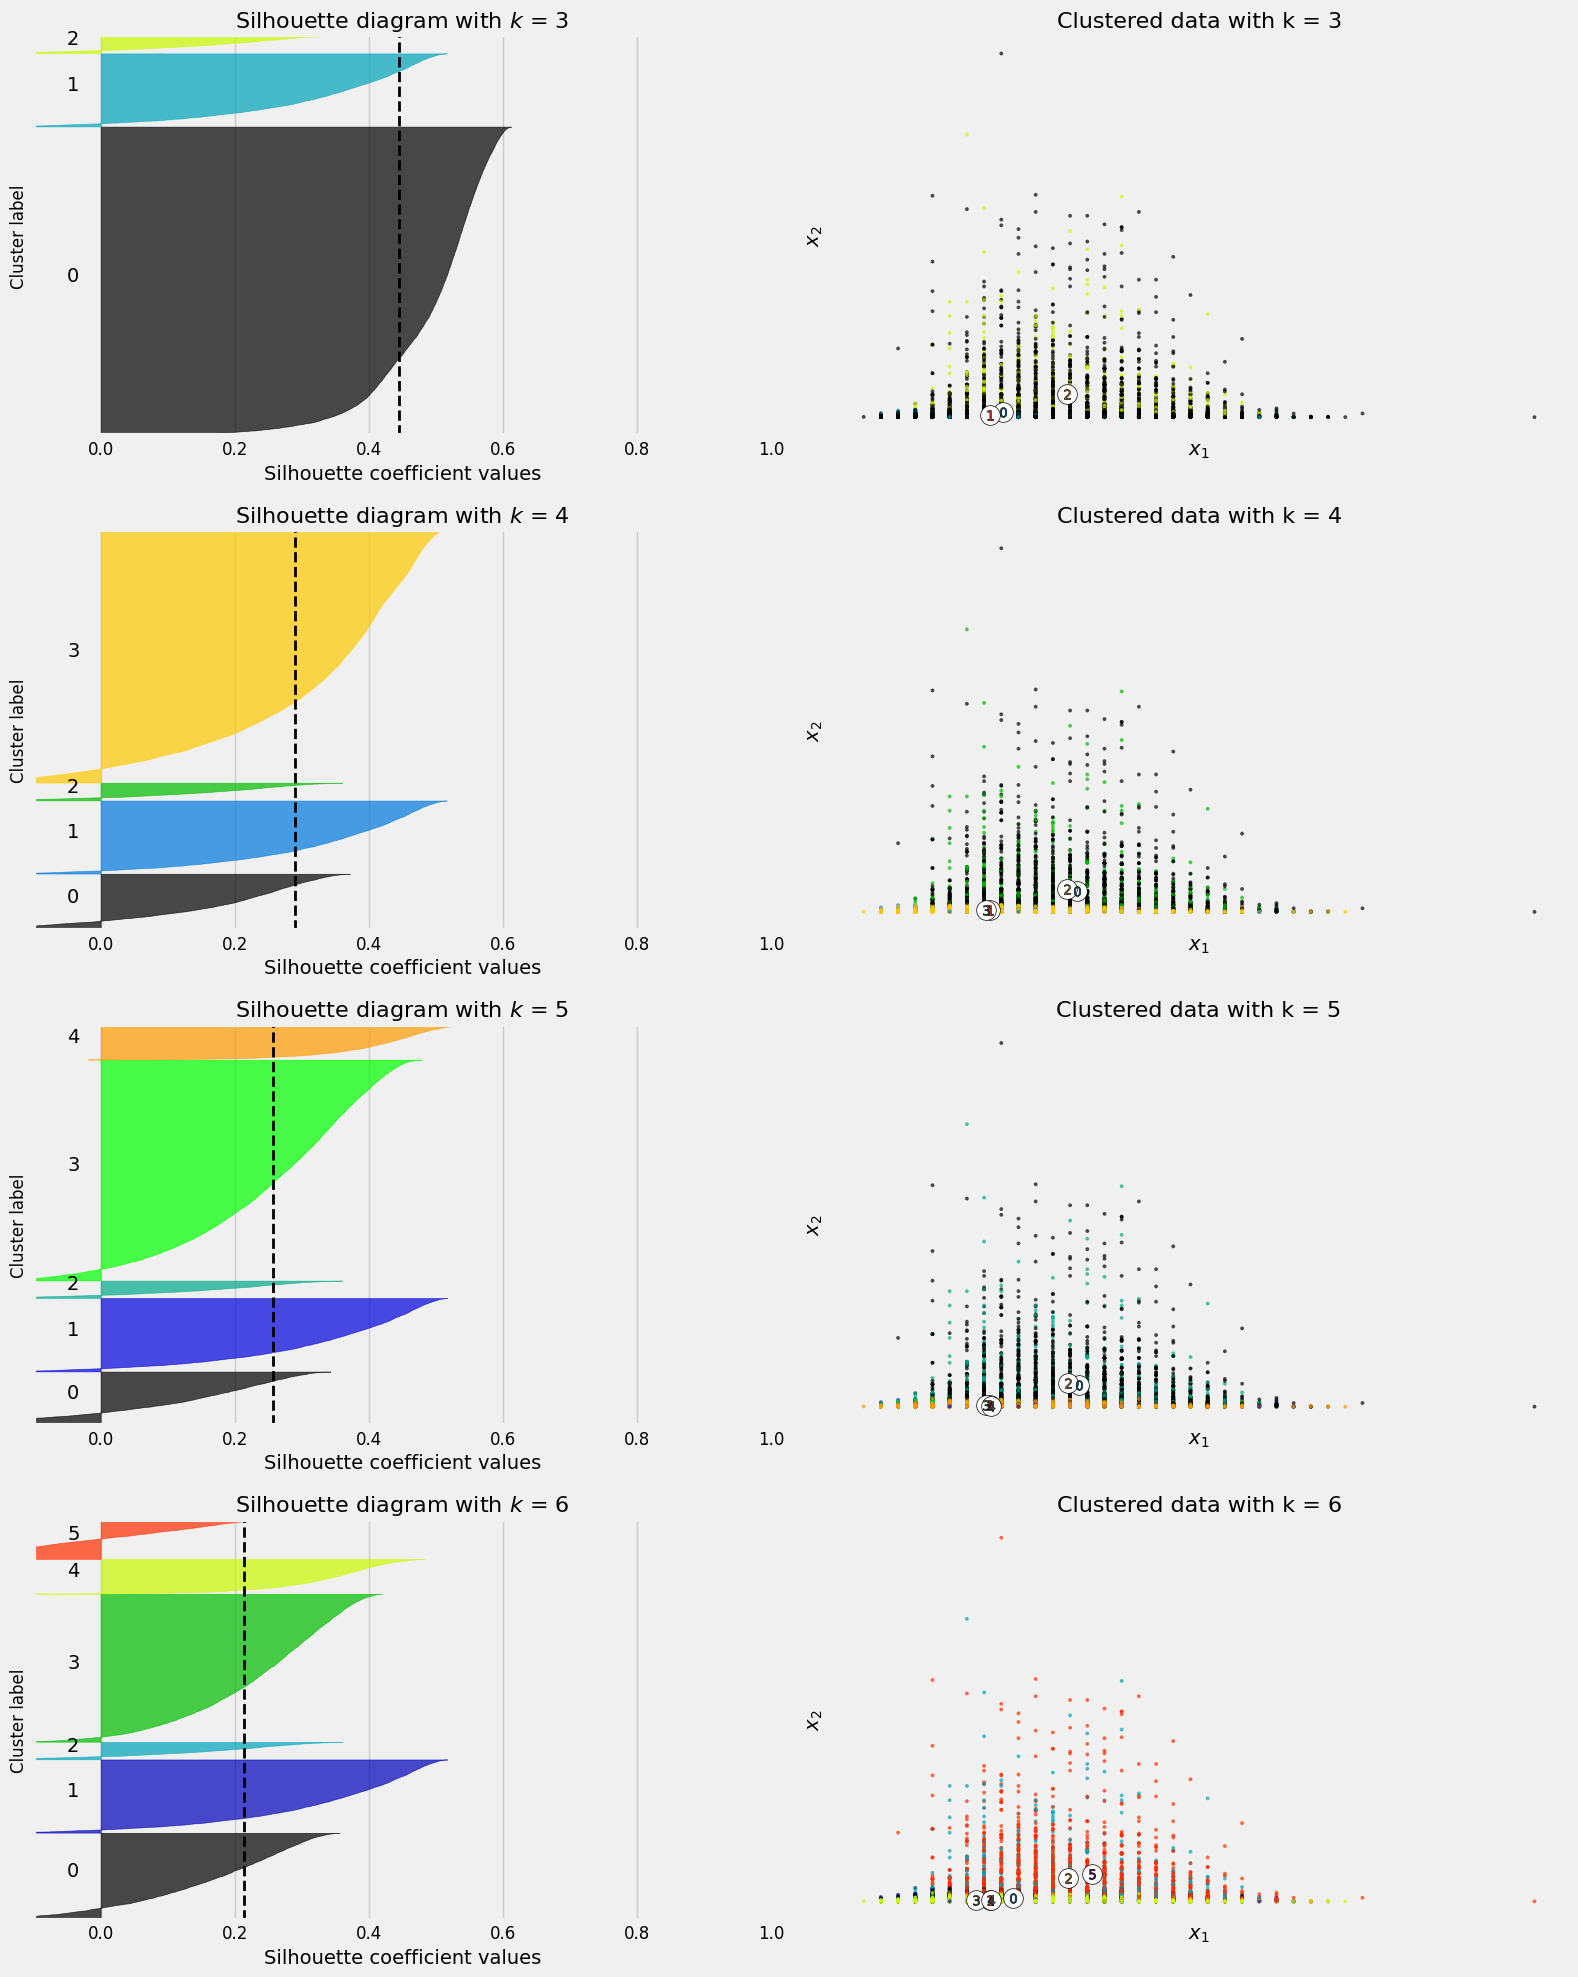

In [27]:
range_n_clusters = [3, 4, 5, 6]

fig, ax = plt.subplots(4, 2, figsize=(16, 20))

# [0, 0] [0, 1]
# [1, 0] [1, 1]
# [2, 0] [2, 1]
# [3, 0] [3, 1]

for row, n_clusters in enumerate(range_n_clusters):

  # Create a subplot with 1 row and 2 columns
  # fig, (ax1, ax2) = plt.subplots(1, 2)

  # fig.set_size_inches(12, 6)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax[row, 0].set_xlim([-0.1, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax[row, 0].set_ylim([0, len(fifa_df) + (n_clusters + 1) * 10])

  # get predictions for each label
  cluster_labels = gmm_models[n_clusters-2].predict(fifa_df)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(fifa_df, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette score for each sample
  sample_silhouette_values = silhouette_samples(fifa_df, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[row, 0].fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax[row, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[row, 0].set_title("Silhouette diagram with $k$ = {}".format(n_clusters), fontsize=16)
  ax[row, 0].set_xlabel("Silhouette coefficient values", fontsize=14)
  ax[row, 0].set_ylabel("Cluster label", fontsize=12)

  ax[row, 0].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax[row, 0].tick_params(axis='both', which='major', labelsize=12)

  # The vertical line for average silhouette score of all the values
  ax[row, 0].axvline(x=silhouette_avg, color="black", linestyle="--", linewidth=2)

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax[row, 1].scatter(fifa_df.iloc[:, 0], fifa_df.iloc[:, 3], marker='.', s=30, lw=0, alpha=0.7,
                     c=colors, edgecolor='k')

  # Labeling the clusters
  centers = gmm_models[n_clusters-2].means_
  # Draw white circles at cluster centers
  ax[row, 1].scatter(centers[:, 0], centers[:, 3], marker='o',
                     c="white", alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax[row, 1].scatter(c[0], c[3], marker='$%d$' % i, alpha=1,
                       s=50, edgecolor='k')

  ax[row, 1].set_title(f"Clustered data with k = {n_clusters}", fontsize=16)
  ax[row, 1].set_xlabel("$x_1$", fontsize=14)
  ax[row, 1].set_ylabel("$x_2$", fontsize=14)
  ax[row, 1].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 1].set_xticks([])

  ax[row, 1].grid(False)

  # fig.suptitle(("Silhouette analysis for KMeans clustering "
  # "with $k$ = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("silhouette_diagram.png", dpi=650, transparent=False)
plt.show()

### Resumen silueta

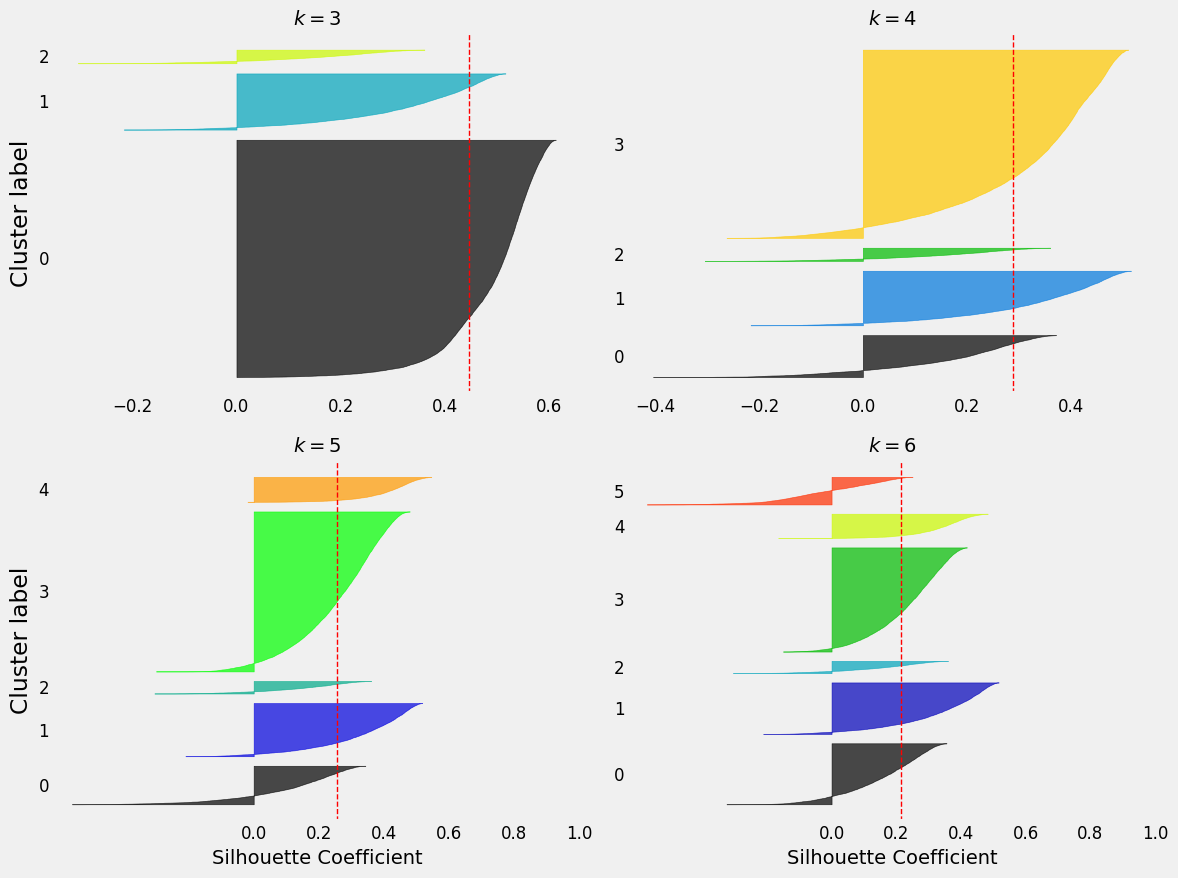

In [28]:
plt.figure(figsize=(12, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = gmm_models[k - 2].predict(fifa_df)
    silhouette_coefficients = silhouette_samples(fifa_df, y_pred)

    padding = len(fifa_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.nipy_spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster label")

    if k in (5, 6):
      plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
      plt.xlabel("Silhouette Coefficient", fontsize=14)
    # else:
    #     plt.tick_params(labelbottom=False)
    plt.tick_params(labelsize=12)
    plt.axvline(x=silhouettes[k - 2], color="red", linestyle="--", linewidth=1)
    plt.title("$k={}$".format(k), fontsize=14, fontweight="bold")

    plt.grid(False)

plt.tight_layout()
plt.show()

### Regiones de decision

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


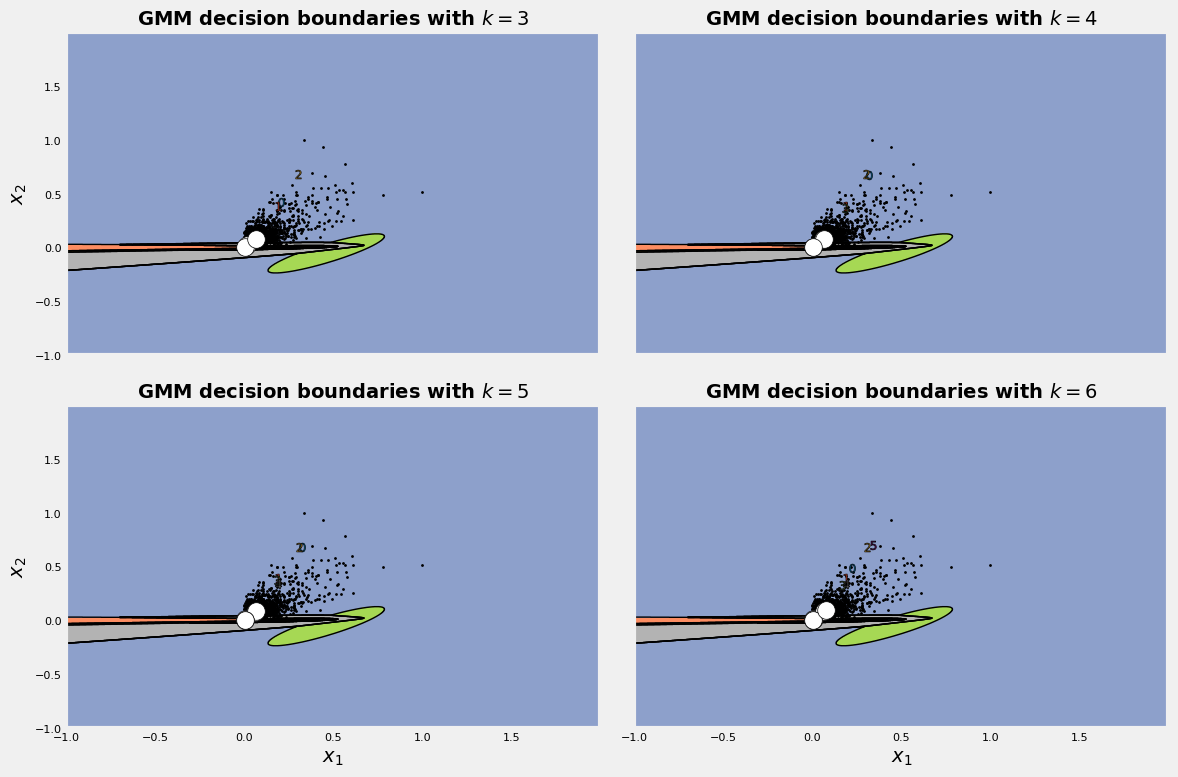

In [29]:
# Seleccionamos dos features relevantes
X_2d = fifa_df[['overall', 'value']]
# Entrenar GMM en este subconjunto

gmm_2d = GaussianMixture(n_components=k, random_state=SEED)
gmm_2d.fit(X_2d)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = fifa_df.iloc[:, 3].min() - 1, fifa_df.iloc[:, 4].max() + 1
y_min, y_max = fifa_df.iloc[:, 3].min() - 1, fifa_df.iloc[:, 4].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# [0, 0] [0, 1]
# [1, 0] [1, 1]

for i, j, k in zip([0, 0, 1, 1], [0, 1, 0, 1], [3, 4, 5, 6]):

  # Obtain labels for each point in mesh. Use last trained model.
  Z = gmm_2d.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  ax[i, j].contourf(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap="Set2")
  ax[i, j].contour(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              linewidths=1, colors='k')

  ax[i, j].plot(fifa_df.iloc[:, 3], fifa_df.iloc[:, 4], 'k.', markersize=2)

  centers = gmm_models[k-2].means_
  ax[i, j].scatter(centers[:, 3], centers[:, 4], marker='o',
                  c="white", alpha=1, s=160, edgecolor='k', zorder=5)
  for cluster_idx, c in enumerate(centers):
    ax[i, j].scatter(c[0], c[1], marker='$%d$' % cluster_idx, alpha=1,
                    s=40, edgecolor='k', zorder=10)

  ax[i, j].set_title("GMM decision boundaries with $k = {}$".format(k),
                    fontsize=14, fontweight="bold")

  if k % 2 == 1:
    ax[i, j].set_ylabel("$x_2$", fontsize=14)

  if k >= 5:
    ax[i, j].set_xlabel("$x_1$", fontsize=14)

  ax[i, j].tick_params(axis='both', labelsize=8)

  ax[i, j].grid(False)

plt.tight_layout()
plt.savefig("decision_boundaries.png", dpi=800, transparent=True)
plt.show()

In [30]:
# from sklearn.decomposition import PCA, KernelPCA

# # Reducir dimensionalidad a 2 componentes
# pca = PCA(n_components=2)
# X_reduced = pca.fit_transform(fifa_df)

# # Entrenar KMeans en el espacio reducido
# kmeans_2d = KMeans(n_clusters=3, random_state=SEED)
# kmeans_2d.fit(X_reduced)

# # Definir la malla en el espacio reducido
# x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
# y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Predecir etiquetas en la malla
# Z = kmeans_2d.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Graficar la frontera de decisión
# plt.contourf(xx, yy, Z, cmap="Set2", alpha=0.4)
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_2d.labels_, s=30, edgecolor='k')
# plt.title(f"Frontera de decisión para k = {k}")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.show()

In [31]:
# kernel_pca = KernelPCA(
#     n_components=2, kernel="poly")
# # Load our dataset X
# X = fifa_df.values
# # Fit the kernel PCA model
# projectedZ = kernel_pca.fit_transform(X)
# BasisW = kernel_pca.eigenvectors_
# print('Input Space:',fifa_df.values.shape)
# print('Latent Space:',projectedZ.shape)
# print(kernel_pca.eigenvalues_)
# print(BasisW.shape)

In [32]:
# from sklearn.decomposition import PCA, KernelPCA

# # Reducir dimensionalidad a 2 componentes
# kernel_pca = KernelPCA(
#     n_components=2, kernel="rbf")
# X_reduced = kernel_pca.fit_transform(fifa_df)

# # Entrenar KMeans en el espacio reducido
# kmeans_2d = KMeans(n_clusters=3, random_state=SEED)
# kmeans_2d.fit(X_reduced)

# # Definir la malla en el espacio reducido
# x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
# y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Predecir etiquetas en la malla
# Z = kmeans_2d.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Graficar la frontera de decisión
# plt.contourf(xx, yy, Z, cmap="Set2", alpha=0.4)
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_2d.labels_, s=30, edgecolor='k')
# plt.title(f"Frontera de decisión para k = {k}")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.show()

In [33]:
# from sklearn.manifold import TSNE

# t_sne = TSNE(n_components=2, perplexity=0.5)
# # Reducir dimensionalidad a 2 componentes
# X_reduced = t_sne.fit_transform(fifa_df)

# # Entrenar KMeans en el espacio reducido
# kmeans_2d = KMeans(n_clusters=3, random_state=SEED)
# kmeans_2d.fit(X_reduced)

# # Definir la malla en el espacio reducido
# x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
# y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Predecir etiquetas en la malla
# Z = kmeans_2d.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Graficar la frontera de decisión
# plt.contourf(xx, yy, Z, cmap="Set2", alpha=0.4)
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_2d.labels_, s=30, edgecolor='k')
# plt.title(f"Frontera de decisión para k = {k}")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.show()